In [1280]:
import pandas as pd
import pdfplumber
import numpy as np
from utils import *

## Table detection


In [1281]:
# pdf_restric

In [1282]:
pdf_path = "mcs2024.pdf"

material = 'Sand and Gravel'

p = 159


pdf_restric = {material: [p, p+1]}

selected_p = p

scraping_base = extract_positions_for_elements(pdf_path, pdf_restric)

selected_content = 'content_1'

if selected_content == 'content_1':
    selected_p = p - 1
else:
    selected_p = p

selected_page = scraping_base[material][selected_content]
df = selected_page
page_text_df = selected_page


bounding_box = extract_cols(page_text_df, 'x1', 2)

In [1283]:
# pdf_path = "mcs2024.pdf"

# material = 'ABRASIVES'

# p = 34


# pdf_restric = {material: [p, p+1]}

# selected_p = p

# scraping_base = extract_positions_for_elements(pdf_path, pdf_restric)

# selected_content = 'content_2'

# if selected_content == 'content_1':
#     selected_p = p - 1
# else:
#     selected_p = p

# selected_page = scraping_base[material][selected_content]
# df = selected_page
# page_text_df = selected_page


# bounding_box = extract_cols(page_text_df, 'x1', 2)

In [1284]:
# Compute margin_top
# refering to previous word (in reading order)
df['margin_top'] = df['bottom'] - df['top'].shift(1)

# Fill the last value of margin_top with 0 or NaN as it has no preceding word
df['margin_top'] = df['margin_top'].fillna(0)

# set margin_top to 0 words in same line
df['margin_top'] = df.apply(lambda row: 0 if row['top'] == df['top'].shift(
    1).loc[row.name] else row['margin_top'], axis=1)

gap_y_df = df[df['margin_top'] > 27]
# Perspective : change threshold using statistic (example : quantile 75 of margin_top)

In [1285]:
# bounding_box['max_top_class'] = bounding_box['max_top'].apply(convert_to_class).astype(int)

# # Count occurrences of each value in 'max_top_class'
# class_counts = bounding_box['max_top_class'].value_counts()

# # Filter the dataframe to remove rows where 'max_top_class' exists only once
# bounding_box = bounding_box[bounding_box['max_top_class'].isin(class_counts[class_counts > 1].index)]

In [1286]:
# bounding_box['min_bottom_class'] = bounding_box['min_bottom'].apply(convert_to_class).astype(int)

# # Count occurrences of each value in 'max_top_class'
# class_counts = bounding_box['min_bottom_class'].value_counts()

# # Filter the dataframe to remove rows where 'max_top_class' exists only once
# bounding_box = bounding_box[bounding_box['min_bottom_class'].isin(class_counts[class_counts > 1].index)]

In [1287]:
bounding_box

,x1,min_bottom,max_top
0,297.71,422.1765,192.64752
1,297.72,444.1965,203.17650
2,351.71,422.1765,214.15650
3,351.72,444.1965,191.37648


In [1288]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assuming bounding_box is already defined as a DataFrame

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

combined_data = np.concatenate(
    (bounding_box[['min_bottom']], bounding_box[['max_top']]), axis=0)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the combined data
normalized_combined_data = scaler.fit_transform(combined_data)

# Split the combined data back into two columns
split_index = len(bounding_box)
normalized_min_bottom = normalized_combined_data[:split_index]
normalized_max_top = normalized_combined_data[split_index:]

# Assign the scaled values back to the DataFrame
bounding_box['min_bottom_normalized'] = np.round(normalized_min_bottom, 0)
bounding_box['max_top_normalized'] = np.round(normalized_max_top, 0)

In [1289]:
bounding_box

,x1,min_bottom,max_top,min_bottom_normalized,max_top_normalized
0,297.71,422.1765,192.64752,1.0,0.0
1,297.72,444.1965,203.17650,1.0,0.0
2,351.71,422.1765,214.15650,1.0,0.0
3,351.72,444.1965,191.37648,1.0,0.0


In [1290]:
# Group by 'min_bottom_normalized' and 'max_top_normalized'
grouped = bounding_box.groupby(['min_bottom_normalized'])

# Convert each group into a separate dataframe and store them in a list
list_of_dfs = [group.reset_index(drop=True) for _, group in grouped]

list_of_top_bottom_bbox = []
for _, group in grouped:
    if len(group) > 1:
        list_of_top_bottom_bbox.append({
            'bbox_top': float(group['max_top'].min()),
            'bbox_bottom': float(group['min_bottom'].max())
        })

In [1291]:
list_of_top_bottom_bbox

[{'bbox_top': 191.37648000000002, 'bbox_bottom': 444.1965}]

In [1292]:
list_of_bbox = []
list_of_table_df = []
for top_bottom_bbox in list_of_top_bottom_bbox:
    bbox_top, bbox_bottom = top_bottom_bbox['bbox_top'], top_bottom_bbox['bbox_bottom']

    # Find the nearest 'top' and 'bottom' values in the dataframe
    gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)
    gap_y_df['bottom_diff'] = np.abs(gap_y_df['bottom'] - bbox_bottom)
    gap_y_df['total_diff'] = gap_y_df['top_diff'] + gap_y_df['bottom_diff']

    # Get the row with the minimum total difference
    nearest_row = gap_y_df.loc[gap_y_df['total_diff'].idxmin()]
    nearest_row['top']

    # Calculate the differences between bbox_top and the 'top' values in the dataframe
    gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)

    # Find the row with the minimum 'top_diff' and maximum 'bottom_diff'
    nearest_top_row = gap_y_df.loc[gap_y_df['top_diff'].idxmin()]

    # Filter the dataframe to only include rows with the nearest 'top' and 'bottom' values
    nearest_top_df = gap_y_df[gap_y_df['top'] == nearest_top_row['top']]
    bbox_top_final, bbox_bottom_final = nearest_top_df['top'], bbox_bottom

    padding = 5

    bbox_top_final, bbox_bottom_final = float(
        nearest_top_df['top']), float(bbox_bottom)

    table_df = page_text_df[(page_text_df['top'] >= bbox_top_final - padding)
                            & (page_text_df['bottom'] <= bbox_bottom_final + padding)]

    bbox_start, bbox_end = float(
        table_df['x0'].min()), float(table_df['x1'].max())

    list_of_bbox.append({
        'bbox_top': bbox_top_final,
        'bbox_bottom': bbox_bottom_final,
        'bbox_start': bbox_start,
        'bbox_end': bbox_end
    })
    list_of_table_df.append(table_df)

C:\Users\DataScience\AppData\Local\Temp\ipykernel_118300\1143877381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_y_df['top_diff'] = np.abs(gap_y_df['top'] - bbox_top)
C:\Users\DataScience\AppData\Local\Temp\ipykernel_118300\1143877381.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gap_y_df['bottom_diff'] = np.abs(gap_y_df['bottom'] - bbox_bottom)
C:\Users\DataScience\AppData\Local\Temp\ipykernel_118300\1143877381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [1293]:
list_of_bbox

[{'bbox_top': 181.66751999999997,
  'bbox_bottom': 444.1965,
  'bbox_start': 44.94,
  'bbox_end': 526.3559879999999}]

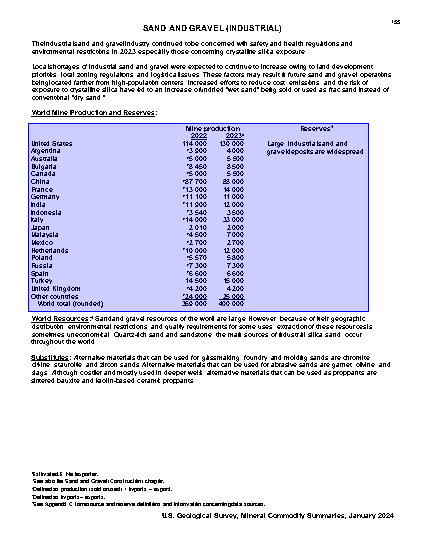

In [1294]:
with pdfplumber.open("mcs2024.pdf") as pdf:
    im = pdf.pages[selected_p].to_image(resolution=50)

# Draw a rectangle using the bounding box coordinates
border_color = "blue"

for bbox in list_of_bbox:
    # Draw a rectangle using the bounding box coordinates with specified colors
    im.draw_rect([bbox['bbox_start'] - padding, bbox['bbox_top'] - padding, bbox['bbox_end'] + padding, bbox['bbox_bottom'] + padding],
                 stroke=border_color, stroke_width=1)

im

In [1295]:
# STOP HERE

## Table to Dataframe


In [1296]:
import re

# Remove special characters from 'text'
table_df['text'] = table_df['text'].apply(lambda x: re.sub(r'\W+', '', x))

C:\Users\DataScience\AppData\Local\Temp\ipykernel_118300\1481100593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_df['text'] = table_df['text'].apply(lambda x: re.sub(r'\W+', '', x))


In [1297]:
table_df

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
111,Mine,267.660000,290.453496,181.66752,122976.00108,191.68752,True,10.02000,22.793496,ltr,32.01900
112,production,293.222022,345.493356,181.66752,122976.00108,191.68752,True,10.02000,52.271334,ltr,0.00000
113,Reserves4,432.420000,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14000
114,2022,275.400000,297.714540,192.64752,122986.98108,202.66752,True,10.02000,22.314540,ltr,22.15104
115,2023e,325.800000,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02000
...,...,...,...,...,...,...,...,...,...,...,...
190,World,54.120000,80.271198,434.17650,123228.51006,444.19650,True,10.02000,26.151198,ltr,21.06000
191,total,83.041728,101.947464,434.17650,123228.51006,444.19650,True,10.02000,18.905736,ltr,0.00000
192,rounded,104.702964,148.125636,434.17650,123228.51006,444.19650,True,10.02000,43.422672,ltr,0.00000
193,359000,261.540000,297.716208,434.17650,123228.51006,444.19650,True,10.02000,36.176208,ltr,0.00000


In [1298]:
# filter indices (smaller than most used text height)

mode_height = table_df['height'].mode()[0]

table_df = table_df[table_df['height'] > round(mode_height, 0)]

In [1299]:
table_df[table_df['height'] > mode_height]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
113,Reserves4,432.42,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14
115,2023e,325.80,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02
125,e3900,269.04,297.714048,213.06600,123007.39956,224.17650,True,11.11050,28.674048,ltr,10.02
132,e5000,269.04,297.714048,224.04600,123018.37956,235.15650,True,11.11050,28.674048,ltr,10.02
135,e8450,269.04,297.714048,235.08600,123029.41956,246.19650,True,11.11050,28.674048,ltr,10.02
138,e5000,269.04,297.714048,246.06600,123040.39956,257.17650,True,11.11050,28.674048,ltr,10.02
141,e87700,263.46,297.715188,257.04600,123051.37956,268.15650,True,11.11050,34.255188,ltr,10.02
144,e13000,263.46,297.715188,268.08600,123062.41956,279.19650,True,11.11050,34.255188,ltr,10.02
147,e11100,263.46,297.715188,279.06600,123073.39956,290.17650,True,11.11050,34.255188,ltr,10.02
150,e11900,263.46,297.715188,290.04600,123084.37956,301.15650,True,11.11050,34.255188,ltr,10.02


In [1300]:
# # Filter rows where 'height' is greater than mode_height to delete indice from string
# filtered_df = table_df[table_df['height'] > mode_height]

# # Function to remove the last string from a given string
# def remove_last_string(s):  # remove non digit char🔴
#     s = s.strip()
#     return s[:-1]

# # Apply the function to the 'row' column of the filtered DataFrame
# filtered_df['text'] = filtered_df['text'].apply(remove_last_string)

# # Update the original DataFrame with the modified values
# table_df.loc[table_df['height'] > mode_height, 'text'] = filtered_df['text']

In [1301]:
table_df[table_df['height'] > mode_height]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
113,Reserves4,432.42,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14
115,2023e,325.80,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02
125,e3900,269.04,297.714048,213.06600,123007.39956,224.17650,True,11.11050,28.674048,ltr,10.02
132,e5000,269.04,297.714048,224.04600,123018.37956,235.15650,True,11.11050,28.674048,ltr,10.02
135,e8450,269.04,297.714048,235.08600,123029.41956,246.19650,True,11.11050,28.674048,ltr,10.02
138,e5000,269.04,297.714048,246.06600,123040.39956,257.17650,True,11.11050,28.674048,ltr,10.02
141,e87700,263.46,297.715188,257.04600,123051.37956,268.15650,True,11.11050,34.255188,ltr,10.02
144,e13000,263.46,297.715188,268.08600,123062.41956,279.19650,True,11.11050,34.255188,ltr,10.02
147,e11100,263.46,297.715188,279.06600,123073.39956,290.17650,True,11.11050,34.255188,ltr,10.02
150,e11900,263.46,297.715188,290.04600,123084.37956,301.15650,True,11.11050,34.255188,ltr,10.02


In [1302]:
list_of_table_df[0]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
111,Mine,267.660000,290.453496,181.66752,122976.00108,191.68752,True,10.02000,22.793496,ltr,32.01900
112,production,293.222022,345.493356,181.66752,122976.00108,191.68752,True,10.02000,52.271334,ltr,0.00000
113,Reserves4,432.420000,480.542880,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14000
114,2022,275.400000,297.714540,192.64752,122986.98108,202.66752,True,10.02000,22.314540,ltr,22.15104
115,2023e,325.800000,351.722880,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02000
...,...,...,...,...,...,...,...,...,...,...,...
190,World,54.120000,80.271198,434.17650,123228.51006,444.19650,True,10.02000,26.151198,ltr,21.06000
191,total,83.041728,101.947464,434.17650,123228.51006,444.19650,True,10.02000,18.905736,ltr,0.00000
192,rounded,104.702964,148.125636,434.17650,123228.51006,444.19650,True,10.02000,43.422672,ltr,0.00000
193,359000,261.540000,297.716208,434.17650,123228.51006,444.19650,True,10.02000,36.176208,ltr,0.00000


In [1303]:
comb_table_df = complexe_word(list_of_table_df[0], 0)   # until here it's good

In [1304]:
# comb_table_df[:50].to_csv('sample.csv')

In [1305]:
# comb_table_df['bottom'] = round(comb_table_df['bottom'], 0)

In [1306]:
comb_table_df

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top
0,Mine production,268.0,345.0,181.66752,122976.00108,191.68752,True,10.02000,77.000000,ltr,32.01900
1,Reserves4,432.0,481.0,180.51648,122974.85004,191.80752,True,11.29104,48.122880,ltr,10.14000
2,2022,275.0,298.0,192.64752,122986.98108,202.66752,True,10.02000,22.314540,ltr,22.15104
3,2023e,326.0,352.0,191.37648,122985.71004,202.66752,True,11.29104,25.922880,ltr,10.02000
4,United States,45.0,105.0,203.17650,122997.51006,213.19650,True,10.02000,60.000000,ltr,21.82002
...,...,...,...,...,...,...,...,...,...,...,...
67,e24000,263.0,298.0,422.04600,123216.37956,433.15650,True,11.11050,34.255188,ltr,10.02000
68,25000,321.0,352.0,423.13650,123217.47006,433.15650,True,10.02000,30.655188,ltr,11.11050
69,World total rounded,54.0,148.0,434.17650,123228.51006,444.19650,True,10.02000,94.000000,ltr,21.06000
70,359000,262.0,298.0,434.17650,123228.51006,444.19650,True,10.02000,36.176208,ltr,0.00000


In [1307]:
def belongs_to_same_group(row1, row2):
    # Check if intervals [x0, x1] of row1 and row2 overlap
    interval1_start, interval1_end = min(row1['x0'], row1['x1']), max(row1['x0'], row1['x1'])
    interval2_start, interval2_end = min(row2['x0'], row2['x1']), max(row2['x0'], row2['x1'])
    
    intervals_overlap = not (interval1_end < interval2_start or interval2_end < interval1_start)
    condition = intervals_overlap and row1['bottom'] != row2['bottom']
    return condition

groups = []

# Iterate through each combination of rows to form groups
for i, row1 in comb_table_df.iterrows():
    added_to_any_group = False
    for group in groups:
        if any(belongs_to_same_group(row1, comb_table_df.iloc[j]) for j in group):
            group.append(i)
            added_to_any_group = True
    if not added_to_any_group:
        groups.append([i])

# Add group labels to the dataframe
comb_table_df['group'] = -1
group_label = 0
for group in groups:
    for index in group:
        if comb_table_df.at[index, 'group'] == -1:  # Assign a new group label if not already assigned
            comb_table_df.at[index, 'group'] = group_label
    group_label += 1

In [1308]:
# com

In [1309]:
comb_table_df['group'].unique().tolist()

[0, 1, 2]

In [1310]:
unique_groups = comb_table_df['group'].unique()

dfs = []

# Loop over the unique values and create a DataFrame for each group
for group in unique_groups:
    df_group = comb_table_df[comb_table_df['group'] == group]
    dfs.append(df_group)


In [1311]:
group_counter = 1
to_merge = []

for df in dfs[:]:
    # Check if there are any duplicated 'bottom' values
    if df['bottom'].duplicated().any():
        unique_x1 = df['x1'].unique()
        for x1 in unique_x1:
            df.loc[df['x1'] == x1, 'TEST'] = group_counter
            group_counter += 1
    else:
        to_merge.append(df)

dfs = [df for df in dfs if id(df) not in [id(d) for d in to_merge]]
new_dfs = []

for df in dfs[:]:
    unique_tests = df['TEST'].dropna().unique()  # Get unique TEST values, ignoring NaNs
    for test_value in unique_tests:
        temp_df = df[df['TEST'] == test_value].copy()
        if len(temp_df) > 1:  # Check if this subset has repeated values
            new_dfs.append(temp_df)
            df.drop(temp_df.index, inplace=True)  # Remove these rows from the original DataFrame

    # Now handle the remaining elements in df
    if not df.empty:  # Check if there are remaining elements in df
        for new_df in new_dfs:
            # Merge remaining elements with new_dfs
            df_merged = pd.concat([new_df, df]).drop_duplicates().reset_index(drop=True)
            new_dfs.append(df_merged)
        # Remove the original df since it has been merged
        dfs.remove(df)

# Append the new DataFrames to the original list
dfs.extend(new_dfs)

# for df in dfs[:]:
    # make each elements with same TEST value on a new df, append it to dfs if this is repeated at least once, and eraze it from the old df

C:\Users\DataScience\AppData\Local\Temp\ipykernel_118300\1241130628.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['x1'] == x1, 'TEST'] = group_counter
C:\Users\DataScience\AppData\Local\Temp\ipykernel_118300\1241130628.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(temp_df.index, inplace=True)  # Remove these rows from the original DataFrame


KeyboardInterrupt: 

In [ ]:
dfs[0]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top,group,TEST
0,Mine production,268.0,345.0,181.66752,122976.00108,191.68752,True,10.02,77.0,ltr,32.019,0,1.0


In [ ]:
to_merge[1]

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top,group
4,United States,45.0,105.0,203.1765,122997.51006,213.1965,True,10.02,60.000000,ltr,21.82002,2
8,Argentina,45.0,88.0,214.1565,123008.49006,224.1765,True,10.02,42.834498,ltr,20.28000,2
12,Australia,45.0,84.0,225.1365,123019.47006,235.1565,True,10.02,38.933712,ltr,20.28000,2
15,Bulgaria,45.0,82.0,236.1765,123030.51006,246.1965,True,10.02,36.715284,ltr,21.06000,2
18,Canada,45.0,80.0,247.1565,123041.49006,257.1765,True,10.02,35.094048,ltr,21.00000,2
21,China,45.0,71.0,258.1365,123052.47006,268.1565,True,10.02,26.152200,ltr,21.00000,2
24,France,45.0,76.0,269.1765,123063.51006,279.1965,True,10.02,31.192260,ltr,21.06000,2
27,Germany,45.0,86.0,280.1565,123074.49006,290.1765,True,10.02,41.132100,ltr,21.00000,2
30,India,45.0,67.0,291.1365,123085.47006,301.1565,True,10.02,21.713340,ltr,21.00000,2
33,Indonesia,45.0,88.0,302.1765,123096.51006,312.1965,True,10.02,43.435698,ltr,21.06000,2


In [ ]:
# Concatenate all DataFrames in the to_merge list
def custom_outer_merge(df1, df2, iteration):
    merged = []
    used_indices_df2 = set()
    for i, row1 in df1.iterrows():
        match = False
        for j, row2 in df2.iterrows():
            if abs(row1['bottom'] - row2['bottom']) <= 10 and j not in used_indices_df2:
                combined_row = row1.to_dict()
                combined_row[f'text_{iteration}'] = row2['text']
                merged.append(combined_row)
                used_indices_df2.add(j)
                match = True
                break
        if not match:
            combined_row = row1.to_dict()
            combined_row[f'text_{iteration}'] = None
            merged.append(combined_row)
    
    for j, row2 in df2.iterrows():
        if j not in used_indices_df2:
            combined_row = {col: None for col in df1.columns if col.startswith('text')}
            combined_row['bottom'] = row2['bottom']
            combined_row[f'text_{iteration}'] = row2['text']
            merged.append(combined_row)
    
    return pd.DataFrame(merged)

def merge_list_of_dataframes(dfs):
    if not dfs:
        return pd.DataFrame()

    merged_df = dfs[0][['text', 'bottom']]
    for i in range(1, len(dfs)):
        merged_df = custom_outer_merge(merged_df, dfs[i][['text', 'bottom']], i)

    return merged_df

if to_merge:
    merged_df = merge_list_of_dataframes(to_merge)

dfs = dfs.append(merged_df)

In [ ]:
merged_df.columns

Index(['text', 'bottom', 'text_1'], dtype='object')

In [ ]:
merged_df

,text,bottom,text_1
0,Reserves4,191.80752,None
1,Large Industrial sand and,213.91650,United States
2,gravel deposits are widespread,224.89650,Argentina
3,None,235.15650,Australia
4,None,246.19650,Bulgaria
5,None,257.17650,Canada
6,None,268.15650,China
7,None,279.19650,France
8,None,290.17650,Germany
9,None,301.15650,India


In [ ]:
# for i in comb_table_df['group'].unique().tolist():
#     print('################ ', i)
#     print(comb_table_df[comb_table_df['group'] == i]
#           [['text', 'x0', 'x1', 'bottom']])
#     print()
#     print()

In [ ]:
# grps = comb_table_df[comb_table_df['group'] == 0][['text', 'x0', 'x1', 'bottom']].groupby('x1')
# for cls, grp in grps:
#     print("cls ################ " ,cls)
#     print(grp)
#     print()

In [ ]:
# # Compute margin_top
# df['space_x'] = df['x1'] - df['x0'].shift(1) # refering to previous word (in reading order)

# # Fill the last value of margin_top with 0 or NaN as it has no preceding word
# df['space_x'] = df['space_x'].fillna(0)

# # set margin_top to 0 words in same line
# df['space_x'] = df.apply(lambda row: 0 if row['x0'] == df['x0'].shift(1).loc[row.name] else row['space_x'], axis=1)

# # Perspective : change threshold using statistic (example : quantile 75 of margin_top)

In [ ]:
# gap_x_df = df[df['space_x'] > 100]

# gap_x_df[['text', 'x0', 'x1', 'space_x','bottom']].unqu

In [ ]:
grouped_by_x0 = comb_table_df.groupby('x0')
grouped_by_x1 = comb_table_df.groupby('x1')

# Filter groups with size greater than 2
filtered_groups_by_x0 = grouped_by_x0.filter(lambda x: len(x) > 2)
filtered_groups_by_x1 = grouped_by_x1.filter(lambda x: len(x) > 2)

In [ ]:
filtered_groups_by_x1.sort_values(by='x1').reset_index(drop=True)

,text,x0,x1,top,doctop,bottom,upright,height,width,direction,margin_top,group
0,Poland,45.0,76.0,368.17650,123162.51006,378.19650,True,10.02000,31.195266,ltr,21.06000,2
1,Russia,45.0,76.0,379.15650,123173.49006,389.17650,True,10.02000,30.591060,ltr,21.00000,2
2,Turkey,45.0,76.0,401.17650,123195.51006,411.19650,True,10.02000,30.571020,ltr,21.06000,2
3,France,45.0,76.0,269.17650,123063.51006,279.19650,True,10.02000,31.192260,ltr,21.06000,2
4,e5570,269.0,298.0,367.08600,123161.41956,378.19650,True,11.11050,28.674048,ltr,10.02000,0
5,e2700,269.0,298.0,345.06600,123139.39956,356.17650,True,11.11050,28.674048,ltr,10.02000,0
6,e4500,269.0,298.0,334.08600,123128.41956,345.19650,True,11.11050,28.674048,ltr,10.02000,0
7,2010,273.0,298.0,324.13650,123118.47006,334.15650,True,10.02000,25.074048,ltr,0.00000,0
8,359000,262.0,298.0,434.17650,123228.51006,444.19650,True,10.02000,36.176208,ltr,0.00000,0
9,e14000,263.0,298.0,312.06600,123106.39956,323.17650,True,11.11050,34.255188,ltr,10.02000,0


In [ ]:
# sort x0, take the ones with min x0 +- threshold, they produce the 1st col + erase it from the input data
# sort by x1, min => 2nd col ... + erase it from the input data
# ....

In [ ]:
# comb_table_df = complexe_word(table_df, 0)

In [ ]:
# Define a threshold to group words into lines
threshold = 5  # Adjust this threshold as needed

# Group words into lines
comb_table_df['line_group'] = (
    comb_table_df['top'] - comb_table_df['top'].shift()).abs().gt(threshold).cumsum()

# Create a list of lines where each line is a list of words
lines = comb_table_df.groupby('line_group')['text'].apply(list).tolist()

lines

[['Mine production', 'Reserves4'],
 ['2022', '2023e'],
 ['United States', '114000', '130000', 'Large Industrial sand and'],
 ['Argentina', 'e3900', '4000', 'gravel deposits are widespread'],
 ['Australia', 'e5000', '5500'],
 ['Bulgaria', 'e8450', '8500'],
 ['Canada', 'e5000', '5500'],
 ['China', 'e87700', '88000'],
 ['France', 'e13000', '14000'],
 ['Germany', 'e11100', '11000'],
 ['India', 'e11900', '12000'],
 ['Indonesia', 'e3540', '3500'],
 ['Italy', 'e14000', '33000'],
 ['Japan', '2010', '2000'],
 ['Malaysia', 'e4500', '7000'],
 ['Mexico', 'e2700', '2700'],
 ['Netherlands', 'e10000', '12000'],
 ['Poland', 'e5570', '5800'],
 ['Russia', 'e7300', '7300'],
 ['Spain', 'e6600', '6600'],
 ['Turkey', '14500', '15000'],
 ['United Kingdom', 'e4200', '4200'],
 ['Other countries', 'e24000', '25000'],
 ['World total rounded', '359000', '400000']]

In [ ]:
# lines2 = [line[:len(line)-1] for line in lines]
# lines2

In [ ]:
# lines = lines2

In [ ]:
cells = []
for line in lines:
    cells.append(len(line))

# cols = most_repeated_value(cells)
cols = max(cells)
cols

4

In [ ]:
new_lines = []

for line in lines:
    new_line = []

    # Case: regular line
    if len(line) == cols:
        new_line = line

    # Case: big title all over columns
    elif len(line) == 1:
        new_line = [''] + [line[0] for _ in range(cols - 1)]

    # Case: title for each column except index
    elif len(line) == cols - 1:
        new_line = [''] + line

    # Case: title for two columns
    elif len(line) < cols - 1:
        new_line = [''] + [line[i] for i in range(len(line)) for _ in range(2)]
        # Adjust the new_line length to match cols
        new_line = new_line[:cols]

    new_lines.append(new_line)

In [ ]:
pd.DataFrame(new_lines)

,0,1,2,3
0,,Mine production,Mine production,Reserves4
1,,2022,2022,2023e
2,United States,114000,130000,Large Industrial sand and
3,Argentina,e3900,4000,gravel deposits are widespread
4,,Australia,e5000,5500
5,,Bulgaria,e8450,8500
6,,Canada,e5000,5500
7,,China,e87700,88000
8,,France,e13000,14000
9,,Germany,e11100,11000
